In [2]:
import os
import numpy as np
import pandas as pd
import joblib as jl
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('DummiesV2.csv')

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
targets = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']
X = data.drop(targets, axis=1)
X = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
Y = data[targets].values.argmax(axis=1) # cela réordonne bien les modalités puisque `targets` est ordonnée.
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [5]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          title=None):

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        title = title if title else "Normalized confusion matrix"
    else:
        title = title if title else "Raw confusion matrix"

    sns.set_style('ticks')
    res = sns.heatmap(matrix,
                      cmap=cmap,
                      cbar=True,
                      square=True,
                      annot=True)

    for _, spine in res.spines.items():
        spine.set_visible(True)

    plt.title(title)
    tick_marks = np.arange(len(classes)) + .5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Avec une régression logistique

### Non-équilibrée

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

retrain = False
if not os.path.isfile('regression-log-unbalanced.joblib') or retrain:
    ULR = LogisticRegression(multi_class='multinomial', max_iter=1000)
    selector_ULR = RFECV(ULR, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_ULR, 'regression-log-unbalanced.joblib')
else:
    selector_ULR = jl.load('regression-log-unbalanced.joblib')

ULR = selector_ULR.estimator_

In [7]:
selected_ULR = [variable for variable, boolean in zip(X.columns.tolist(), selector_ULR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(ULR.predict(X_test[selected_ULR]) == Y_test))

Accuracy : 0.6535637040390322


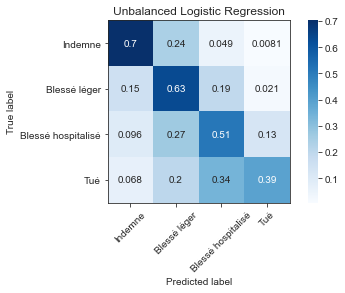

In [8]:
from sklearn import metrics
conf = metrics.confusion_matrix(ULR.predict(X_test[selected_ULR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Logistic Regression');

### Equilibrée

In [9]:
retrain = False
if not os.path.isfile('regression-log-balanced.joblib') or retrain:
    BLR = LogisticRegression(multi_class='multinomial', max_iter=1000, class_weights='balanced')
    selector_BLR = RFECV(BLR, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_BLR, 'regression-log-balanced.joblib')
else:
    selector_BLR = jl.load('regression-log-balanced.joblib')

BLR = selector_BLR.estimator_

In [10]:
selected_BLR = [variable for variable, boolean in zip(X.columns.tolist(), selector_BLR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BLR.predict(X_test[selected_BLR]) == Y_test))

Accuracy : 0.5881997887430209


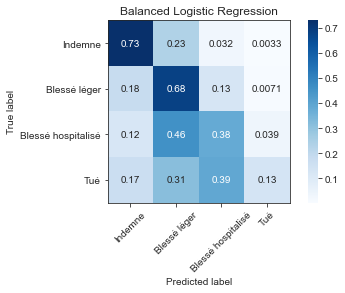

In [11]:
conf = metrics.confusion_matrix(BLR.predict(X_test[selected_BLR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Logistic Regression');

# Avec un Random Forest

### Non-équilibré

In [12]:
from sklearn.ensemble import RandomForestClassifier

retrain = False
if not os.path.isfile('randomforest-unbalanced.joblib') or retrain:
    URF = RandomForestClassifier()
    selector_URF = RFECV(URF, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_URF, 'randomforest-unbalanced.joblib')
else:
    selector_URF = jl.load('randomforest-unbalanced.joblib')

URF = selector_URF.estimator_

In [13]:
selected_URF = [variable for variable, boolean in zip(X.columns.tolist(), selector_URF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(URF.predict(X_test[selected_URF]) == Y_test))

Accuracy : 0.8894924802575324


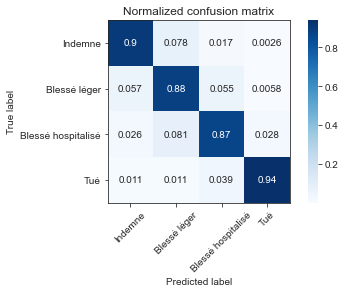

In [14]:
conf = metrics.confusion_matrix(URF.predict(X_test[selected_URF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True);

### Equilibré

In [15]:
retrain = False
if not os.path.isfile('randomforest-balanced.joblib') or retrain:
    BRF = RandomForestClassifier(class_weight='balanced')
    selector_BRF = RFECV(BRF, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_BRF, 'randomforest-balanced.joblib')
else:
    selector_BRF = jl.load('randomforest-balanced.joblib')

BRF = selector_BRF.estimator_

In [16]:
selected_BRF = [variable for variable, boolean in zip(X.columns.tolist(), selector_BRF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BRF.predict(X_test[selected_BRF]) == Y_test))

Accuracy : 0.8893415824153714


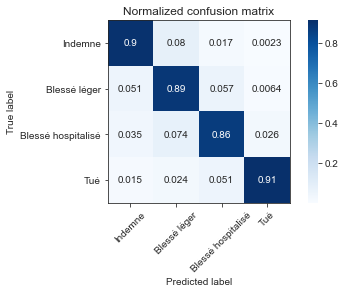

In [17]:
conf = metrics.confusion_matrix(BRF.predict(X_test[selected_BRF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True);

# Variables éliminées par les différents modèles

### Par la régression linéaire

In [18]:
for mod in data.columns.tolist():
    if mod not in targets and mod not in selected_BLR:
        print(mod)

Gilet réflechissant
Airbag
Sens de circulation décroissant
Engin spécial
En stationnement
Propulsion humaine
Intersection à plus de 4 branches
Neige ou grêle
Brouillard ou fumée
Route en pente
Bas de côte
Chaussée enneigée
Chaussée boueuse
Autre état de la chaussée
Sur bande d'arrêt d'urgence
Vitesse limitée à 15km/h
Vitesse limitée à 40km/h
Vitesse limitée à 45km/h
Vitesse limitée à 100km/h
40-59ans
3 voies de circulation
7 voies de circulation
10 voies de circulation
11 voies de circulation


### Par le random forest

In [19]:
for mod in data.columns.tolist():
    if mod not in targets and mod not in selected_BRF:
        print(mod)

Chaussée inondée
Vitesse limitée à 25km/h
Vitesse limitée à 65km/h
Vitesse limitée à 120km/h
Vitesse limitée à 35km/h


In [26]:
BRF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}